# Continuous Control Project Report 

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment
---

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.8 which is incompatible.


The environments corresponding to both versions of the environment are already saved in the Workspace and can be accessed at the file paths provided below.  

Please select one of the two options below for loading the environment.

In [2]:
from unityagents import UnityEnvironment
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline


In [3]:
from ddpg_agent import Agent

In [4]:


# select this option to load version 1 (with a single agent) of the environment
env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')

# select this option to load version 2 (with 20 agents) of the environment
# env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [5]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces
---

Run the code cell below to print some information about the environment.

In [6]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

print('#states:{}, #actions:{}'.format(state_size, action_size))
print('#states:{}, #actions:{}'.format(brain.vector_observation_space_size,brain.vector_action_space_size))

Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33
The state for the first agent looks like: [  0.00000000e+00  -4.00000000e+00   0.00000000e+00   1.00000000e+00
  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -1.00000000e+01   0.00000000e+00
   1.00000000e+00  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   5.75471878e+00  -1.00000000e+00
   5.55726671e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
  -1.68164849e-01]
#states:33, #actions:4
#states:33, #actions:4


### 3. Take Random Actions in the Environment
---
In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [7]:
env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
i=0
while True:
    i+=1
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}, for {} steps'.format(np.mean(scores),i))

Total score (averaged over agents) this episode: 0.0, for 1001 steps


### 4. Description of the Learning Algorithm
---

So the Learnning Algo. is based on :

* Deep Deterministic Gradient Policy (DDGP)
* Noise for randomness to explore more 
* Noise Decay to expliot more as number of epsiodes grow 
* An underlying NNs (defined later below)
* Imporvments used to enhance the Deep DDPQ such as :
 * Replay Buffer
 * Fixed Targets

#### 4.1 First lets Explore the Agent¶
so the Code creates a list of agents to have the flexiblity to use different enviroments versions :
* version 1 of single agent 
* version 2 of 20  agents 

Each agent will have the following 
1. Hyper-Parameters:
 * batch size: 		 1000000
 * buffer size: 		 1000000
 * discount / gamma: 	   0.990
 * actor learning rate: 	   0.001
 * critic learning rate: 	   0.001
 * soft update / tau: 	   0.001
 * noise decay rate: 	   0.999
 
 
2.As DDGP Neural Networks:
 * Actor Local NN :
     * input (state 33 input vector)
     * output (continous actions values for the 4 actions)
 * Actor Target NN:
     * input (state 33 input vector)
     * output (continous actions values for the 4 actions) with fixed target
 * Critic local NN:
     * input (state 33 input vector, action )
     * output (single continous output) the critics' estimate of the current (state,action) pair 
 * Cirtic Target NN:
     * input (state 33 input vector, action )
     * output (1 continous value) the critics' estimate of the current (state,action) pair with fixed target 
 * Hidden layers of 400 followed by 300
 * Batch Normalization on the first hidden layer.

In [8]:
agents=[]
for agent in range(0,num_agents): 
   agents.append(Agent(state_size=brain.vector_observation_space_size, action_size=brain.vector_action_space_size, random_seed=10))

DDPG Agent hyperparameters:
	batch size: 		 1000000
	buffer size: 		 1000000
	discount / gamma: 	   0.990
	actor learning rate: 	   0.001
	critic learning rate: 	   0.001
	soft update / tau: 	   0.001
	noise decay rate: 	   0.999
	
Actor network built: ModuleList(
  (0): Linear(in_features=33, out_features=400, bias=True)
  (1): Linear(in_features=400, out_features=300, bias=True)
  (2): Linear(in_features=300, out_features=4, bias=True)
)
Actor network built: ModuleList(
  (0): Linear(in_features=33, out_features=400, bias=True)
  (1): Linear(in_features=400, out_features=300, bias=True)
  (2): Linear(in_features=300, out_features=4, bias=True)
)
Critic network built: ModuleList(
  (0): Linear(in_features=33, out_features=400, bias=True)
  (1): Linear(in_features=404, out_features=300, bias=True)
  (2): Linear(in_features=300, out_features=1, bias=True)
)
Critic network built: ModuleList(
  (0): Linear(in_features=33, out_features=400, bias=True)
  (1): Linear(in_features=404, out_fea

#### 4.2 Load Previous Progress Option¶
As connection dropped few times , I had to continue from last saved weights 
so the Code uses flag `load_weights` to decide to load critics' and actors' NN weights.

Also, you can get a sense of the last agent's perfomance by running it for an eposide.


In [9]:
len(agents)
load_weights=False

In [10]:
if(load_weights):
    for agent in agents:  # Load per agent last checkpoint
        agent.actor_local.load_state_dict(torch.load('checkpoint_actor.pth'))
        agent.critic_local.load_state_dict(torch.load('checkpoint_critic.pth'))
        agent.soft_update(agent.critic_local, agent.critic_target, 1)
        agent.soft_update(agent.actor_local, agent.actor_target, 1)
    #test agent before continuing trainning
    env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    i=0
    while True:
        i+=1
        actions=[]
        for i in range(num_agents): 
            actions.append(agents[i].act(states[i]))       # select an action (for each agent)
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}, for {} steps'.format(np.mean(scores),i))

### 5. Trainning DDGP
---
In order to Solve this environment, :
    * version 1: A single agent must be able to achieve an average reward (over 100 episodes) of at least 30.
    * version 2: The Avg Reward of the 20 agents per eposide is ( over 100 episodes) of at least 30.
    
   
In order not to waste testing time, the below trainning function breaks upon achieving the solve criteria and prints out Enviroment Solved. However, it is possible that function might return without achieving the criteria.


In [11]:
def ddpg(n_episodes=2000, max_t=1000):
    episode_scores_deque = deque(maxlen=100)
    episode_scores = []     
    max_score = -np.Inf
        
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
        states = env_info.vector_observations                  # get the current state (for each agent)
        scores = np.zeros(num_agents)                          # initialize the score (for each agent)   
        for agent in agents:  agent.reset() #agent.reset() #for agent in agents:  agent.reset()
        
        for t in range(max_t):
            actions=[]
            for i in range(num_agents): 
                actions.append(agents[i].act(states[i]))  # select an action (for each agent)
            env_info = env.step(actions)[brain_name]                    # send all actions to tne environment
            next_states = env_info.vector_observations                  # get next state (for each agent)
            rewards = env_info.rewards                                  # get reward (for each agent)
            dones = env_info.local_done                                 # see if episode finished
            agent.step(states, actions, rewards, next_states, dones)    # update weights (for each agent)
            scores += env_info.rewards                                  # update the score (for each agent)
            states = next_states                                        # roll over states to next time step
            
            if np.any(dones):                                           # exit loop if episode finished
                break
        episode_scores_deque.append(np.mean(scores))            # append the avg score by agents in this eposide
        episode_scores.append(np.mean(scores))                  # append the avg score by agents in this eposide
        print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.2f}'.format(i_episode, np.mean(episode_scores_deque), np.mean(scores)), end="")
        if i_episode % 100 == 0:
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(episode_scores_deque)))
        if np.mean(episode_scores_deque) >= 30.0 :
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(episode_scores_deque)))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            break
    return episode_scores

In [12]:
scores = ddpg()

Episode 100	Average Score: 3.76	Score: 4.49
Episode 200	Average Score: 14.50	Score: 18.79
Episode 300	Average Score: 24.22	Score: 30.86
Episode 400	Average Score: 27.97	Score: 35.71
Episode 496	Average Score: 30.05	Score: 36.92
Environment solved in 496 episodes!	Average Score: 30.05


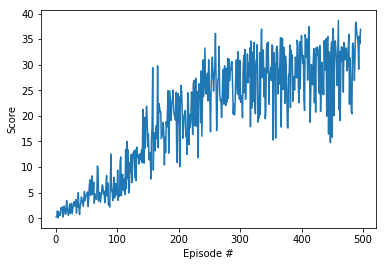

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show() 

### 6. Results
---
Below is graph Heighting:

* Avg Scores achieved by for agent(s) for each Eposide

* The Min score required , orange line, at score 30 to show relatively the perfomance of the agent against the 1st success criteria, ie the minScore

* The Avg Achieved Score, green Line, on the last 100 Episodes which is the 2nd success criteria, ie the MinEposides
* The Avg Achieved Score for last 100 episodes, Red Line, which shows how the Agent's performance improves till it meets the Solve criteria and  stop.

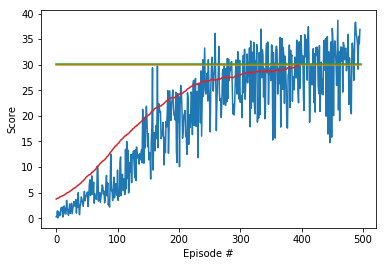

In [28]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores) #scores
plt.plot([0,len(scores)], [30,30]) # Criteria Min Value
plt.plot([0,len(scores)], [np.mean(scores[-100:]),np.mean(scores[-100:])]) # Achieved Mean Score over the last 100 eposides
avg_score=[]
for i in range(100,len(scores)):
    avg_score.append(np.mean(scores[i-100:i]))
    
plt.plot(np.arange(len(scores)-100), avg_score) #scores
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 7. Ideas for Future Work
---

So there is few points that I can tackle on further work:

1. Trying the less Arch as 33 input vector may require less complex architure. :
    * Different layers
    * different neurons / layer
    * Different activations
    * Drophouts
    * Optimizers, etc


2. Searching for best Hyper-parameters mentioned above: 
    * Smaller learning rate
    * Larger UPDATE_EVERY, etc


3. Trying The 2nd Version of 20 Agents where it is applicable to apply different algos :
    * PPO
    * A3C
    * D4PG.


4. Changing the input from the enviroment space and shifiting to pixels

When finished, you can close the environment.

In [ ]:
env.close()